In [1]:
%%HTML
<style>
  @import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

  body {
    font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
    line-height: 1.67;
  }
</style>

# $\mathcal{L}_2$ Dynamic Event-based Control for Island Microgrid

_**[Event-based Control for DC Microgrids](https://github.com/andel-vitorio/fuzzy-based-etc-for-microgrids.git)**_

_by Andevaldo da Encarnação Vitório, Vitoriano Medeiros Casas and Alfredo Silie León (last updated: August 30, 2024)_

This notebook presents the development and implementation of a robust event-based fuzzy controller for an isolated direct current (DC) microgrid connected to constant power loads (CPLs), considering variations in CPLs. The controller, developed through a co-design approach, utilizes state feedback and is designed to reduce the required control tasks. The model, considered nonlinear due to the presence of CPLs and other microgrid characteristics, is subject to disturbances that demand an approach ensuring robust stability through the L2 gain. The design conditions are formulated as linear matrix inequalities (LMI) in a multi-objective optimization problem.

### Package Load and Configurations

In [2]:
import pandas as pd
import math
import cvxpy as cp
from matplotlib.ticker import FuncFormatter
from control.matlab import *
import control.optimal as opt
import control as ct
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

ct.use_fbs_defaults()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Palatino"
})

mpl.rcParams['figure.dpi'] = 75

In [2]:
def show_matrix(matrix, name='ans', decimal_places=2, scientific_notation=True):
  """
  Apresenta uma matriz com a quantidade de casas decimais desejadas.

  Parâmetros:
  ---
  - matrix: numpy.ndarray, a matriz a ser apresentada.
  - casas_decimais: int, o número de casas decimais desejadas (padrão é 2).
  """
  pattern = "{:." + str(decimal_places) + \
      ("e}" if scientific_notation else "f}")

  def format_elem(elem):
    return pattern.format(elem)

  width = [max(map(len, map(format_elem, coluna))) for coluna in matrix.T]

  print(name, "=")

  nspaces = sum(width) + 2 * matrix.shape[1]

  print("    ┌" + " " * nspaces + "┐")
  for line in matrix:
    formatted_line = "  ".join(format_elem(e).rjust(largura)
                               for e, largura in zip(line, width))
    print("    │ " + formatted_line + " │")
  print("    └" + " " * nspaces + "┘")
  print()

In [3]:
def set_subplot(ax, x_data, y_data, xlabel, ylabel, title, label='',
                x_digits=1, y_digits=1, line_color='#120a8f', linewidth=2.,
                title_pad=20, x_label_pad=8, y_label_pad=8,
                y_min=None, y_max=None,
                x_tick_interval=None, y_tick_interval=None):

  # Formatação personalizada do eixo x
  def format_x(value, _):
    return f'{value:.{x_digits}f}'

  # Formatação personalizada do eixo y
  def format_y(value, _):
    return f'{value:.{y_digits}f}'

  ax.xaxis.set_major_formatter(FuncFormatter(format_x))
  ax.yaxis.set_major_formatter(FuncFormatter(format_y))

  # Define os limites do eixo y, se especificados
  if y_min is not None and y_max is not None:
    ax.set_ylim(y_min, y_max)

  # Define a frequência dos ticks do eixo x, se especificada
  if x_tick_interval is not None:
    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))

  # Define a frequência dos ticks do eixo y, se especificada
  if y_tick_interval is not None:
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))

  # Plotando a linha
  line, = ax.plot(x_data, y_data, label=label, linestyle='-',
                  color=line_color, linewidth=linewidth)

  # Configuração dos rótulos e título com tamanhos de fonte ajustados
  ax.set_xlabel(xlabel, fontsize=20, labelpad=x_label_pad)
  ax.set_ylabel(ylabel, fontsize=20, labelpad=y_label_pad)
  ax.grid(linestyle='--')
  ax.set_title(title, fontsize=24, pad=title_pad)

  # Configuração dos parâmetros dos ticks
  ax.tick_params(axis='both', direction='in', length=4, width=1,
                 colors='black', top=True, right=True, labelsize=18)

  # Adicionando a legenda, se fornecida
  if label:
    ax.legend(frameon=True, loc='best', framealpha=1, prop={'size': 16})

  return line

In [4]:
def set_stem(ax, x_data, y_data, xlabel, ylabel, title,
             x_digits=3, y_digits=2, line_color='#120a8f', marker_size=4,
             stem_width=2., title_pad=16, x_label_pad=8, y_label_pad=8, label='',
             x_min=None, x_max=None, y_min=None, y_max=None):

    # Formatação personalizada do eixo x
  def format_x(value, _):
    total_digits = x_digits + y_digits + 1  # +1 para o ponto decimal
    formatted = f'{value:.{y_digits}f}'
    # Alinha à direita com espaços à esquerda
    return f'{formatted:>{total_digits}}'

  # Formatação personalizada do eixo y
  def format_y(value, _):
    total_digits = x_digits + y_digits + 1  # +1 para o ponto decimal
    formatted = f'{value:.{y_digits}f}'
    # Alinha à direita com espaços à esquerda
    return f'{formatted:>{total_digits}}'

  ax.xaxis.set_major_formatter(FuncFormatter(format_x))
  ax.yaxis.set_major_formatter(FuncFormatter(format_y))

  # Plotando o gráfico stem
  markerline, stemlines, baseline = ax.stem(x_data, y_data, linefmt=line_color,
                                            markerfmt='o', basefmt=' ', bottom=0, label=label)
  plt.setp(stemlines, 'linewidth', stem_width)
  plt.setp(markerline, 'markersize', marker_size)

  # Configuração dos rótulos e título com tamanhos de fonte ajustados
  ax.set_xlabel(xlabel, fontsize=20, labelpad=x_label_pad)
  ax.set_ylabel(ylabel, fontsize=20, labelpad=y_label_pad)
  ax.grid(linestyle='--')
  ax.set_title(title, fontsize=24, pad=title_pad)

  # Define os limites do eixo x, se especificados
  if x_min is not None and x_max is not None:
    ax.set_xlim(x_min, x_max)

  # Define os limites do eixo y, se especificados
  if y_min is not None and y_max is not None:
    ax.set_ylim(y_min, y_max)

  # Configuração dos parâmetros dos ticks
  ax.tick_params(axis='both', direction='in', length=4, width=1,
                 colors='black', top=True, right=True, labelsize=18)

  if label:
    ax.legend(frameon=True, loc='best', framealpha=1, prop={'size': 16})

  return markerline, stemlines, baseline

In [5]:
def generate_square_signal(timepts, signal_data):
  signal = np.zeros(len(timepts))
  for i, t in enumerate(timepts):
    for j in range(len(signal_data) - 1):
      if signal_data[j][0] <= t < signal_data[j + 1][0]:
        signal[i] = signal_data[j][1]
        break
    else:
      signal[i] = signal_data[-1][1]
  return signal

In [6]:
L1 = L2 = LK = 1e-3
R11 = R12 = R21 = R22 = RK = 0.1
C1 = C2 = CK = 2.2e-3
RCRL = 20

VE_O = 24

IB_O = 14
VIN1 = 36
VIN2 = 12
VC1_O = 24
VCK_O = 20
PCPL_OP = 50


REQ = (R12 * R22) / (R12 + R22)

ILK_O = VCK_O / RCRL + PCPL_OP / VCK_O  # ok

VC2_O = ((R22 * (RK + REQ)) / REQ) * ILK_O + (R22 / REQ) * \
    VCK_O - (R22 / R12) * VC1_O + R22 * IB_O  # ok

a = - (R21 / VC2_O)
b = VIN2 / VC2_O
c = -((1 / R22) * (1 - (REQ / R22)) *
      VC2_O + (REQ / R22) * ILK_O - (1 / (R12 + R22)) * VC1_O + (REQ / R22) * IB_O)

delta = b**2 - 4 * a * c
print(delta)
x1 = (-b + math.sqrt(delta)) / (2 * a)
x2 = (-b - math.sqrt(delta)) / (2 * a)
print(x1, x2)

IL2_O = x1

D2_O = 1 + (R21 * IL2_O) / VC2_O - VIN2 / VC2_O  # ok

IL1_O = (1 / R12) * (1 - (REQ / R12)) * \
    VC1_O + (REQ / R12) * ILK_O - (1 / (R12 + R22)) * \
    VC2_O + (REQ / R12) * IB_O  # ok

D1_O = (R11 / VIN1) * IL1_O + VC1_O / VIN1  # ok

if (D1_O > 1. or D1_O < 0.) or (D2_O > 1. or D2_O < 0.):
  raise ValueError(f"Ciclo de Trabalhos Inválidos")

# end_time = 0.125e-1
end_time = 1.
# end_time = 0.05
step = 1e-5

# Instantes de tempo
timepts = np.arange(0, end_time + step, step)

Pl = generate_square_signal(
    timepts, [
        (0., PCPL_OP),
        (.1, PCPL_OP + 10),
        (.2, PCPL_OP + 20),
        (.3, PCPL_OP + 5),
        (.4, PCPL_OP + -10),
        (.5, PCPL_OP + 10),
        (.6, PCPL_OP + 15),
        (.7, PCPL_OP + 5),
        (.8, PCPL_OP + -10),
        (.9, PCPL_OP),
    ])

d1 = generate_square_signal(
    timepts, [(.0, D1_O)])

d2 = generate_square_signal(
    timepts, [(.0, D2_O)])

ib = generate_square_signal(
    timepts, [(.0, IB_O)])

npts = len(timepts)

U_OP = np.array([D1_O, D2_O, IB_O, PCPL_OP])
X_OP = np.array([IL1_O, IL2_O, ILK_O, VC1_O, VC2_O, VCK_O])
X0 = 0.95 * X_OP


W_OP = np.array([PCPL_OP])

W = np.array([
    Pl
])

U = [d1, d2, ib, Pl]


print('X_OP = ', X_OP)

print('\nU', U)
print('X0', X0)


δX0 = X0 - X_OP
δU = U - U_OP[:, np.newaxis]
# δU = U - U_OP
δW = W - W_OP[:, np.newaxis]
# δU = U - U_OP


print('\nδU_OP', δU)
print('δX_OP', δX0)

0.8349527397713026
-24.29412790936277 144.29412790936277
X_OP =  [ 36.5        -24.29412791   3.5         24.          18.45
  20.        ]

U [array([0.76805556, 0.76805556, 0.76805556, ..., 0.76805556, 0.76805556,
       0.76805556]), array([0.21791801, 0.21791801, 0.21791801, ..., 0.21791801, 0.21791801,
       0.21791801]), array([14., 14., 14., ..., 14., 14., 14.]), array([50., 50., 50., ..., 50., 50., 50.])]
X0 [ 34.675      -23.07942151   3.325       22.8         17.5275
  19.        ]

δU_OP [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
δX_OP [-1.825      1.2147064 -0.175     -1.2       -0.9225    -1.       ]


In [7]:
def update(t, x, u, params):
  IL1, IL2, ILK, VC1, VC2, VCK = x
  D1, D2, IB, PCPL = u

  DOT_IL1 = - (R11 / L1) * IL1 - (1 / L1) * VC1 + (VIN1 / L1) * D1

  DOT_IL2 = - (R21 / L2) * IL2 - (1 / L2) * (1 - D2) * \
      VC2 + (1 / L2) * VIN2

  DOT_ILK = - ((RK + REQ) / LK) * ILK - (1 / LK) * \
      VCK + (REQ / (R12 * LK)) * VC1 + \
      (REQ / (R22 * LK)) * VC2 - (REQ / LK) * IB

  DOT_VC1 = (1 / C1) * IL1 - (1 / (R12 * C1)) * (1 - (REQ / R12)) * \
      VC1 + (1 / (C1 * (R12 + R22))) * VC2 - \
      (REQ / (R12 * C1)) * IB - (REQ / (R12 * C1)) * ILK

  DOT_VC2 = (1 / C2) * (1 - D2) * IL2 - (1 / (R22 * C2)) * (1 - (REQ / R22)) * VC2 + \
      (1 / (C2 * (R12 + R22))) * VC1 - \
      (REQ / (R22 * C2)) * IB - (REQ / (R22 * C2)) * ILK

  DOT_VCK = (1 / CK) * ILK - (1 / (RCRL * CK)) * VCK - (1 / CK) * (PCPL / VCK)

  DOT_X = [DOT_IL1, DOT_IL2, DOT_ILK, DOT_VC1, DOT_VC2, DOT_VCK]

  return np.array(DOT_X)


def output(t, x, u, params):
  return x


microgrid = ct.ss(update, output, name='microgrid',
                  inputs=('D1', 'D2', 'IB', 'PCPL'),
                  states=('IL1', 'IL2', 'ILK', 'VC1', 'VC2', 'VCK'),
                  outputs=('IL1', 'IL2', 'ILK', 'VC1', 'VC2', 'VCK'))

print(microgrid)

<NonlinearIOSystem>: microgrid
Inputs (4): ['D1', 'D2', 'IB', 'PCPL']
Outputs (6): ['IL1', 'IL2', 'ILK', 'VC1', 'VC2', 'VCK']
States (6): ['IL1', 'IL2', 'ILK', 'VC1', 'VC2', 'VCK']

Update: <function update at 0x72ffae940c10>
Output: <function output at 0x72ffae9415a0>


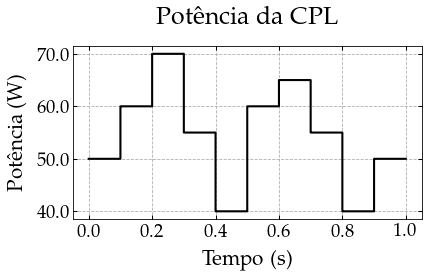

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(6, 3))

# t, y = zip(*scenarios[SCENARIO_TAG]['perturbation_signal_data'])

t = timepts
y = W[0]

# Expandindo os dados para criar um efeito de bloco
t_expanded = []
y_expanded = []

for i in range(len(t) - 1):
  t_expanded.append(t[i])
  t_expanded.append(t[i + 1])
  y_expanded.append(y[i])
  y_expanded.append(y[i])

# Adicionando o último ponto
t_expanded.append(t[-1])
y_expanded.append(y[-1])

# Convertendo para arrays NumPy para plotagem
t_expanded = np.array(t_expanded)
y_expanded = np.array(y_expanded)

set_subplot(
    axs,
    t_expanded,
    y_expanded,
    'Tempo (s)',
    'Potência (W)',
    'Potência da CPL',
    line_color="black"
)

# path = f"../assets/buck-converter/{scenarios[SCENARIO_TAG]['tag']}_PCPL.eps"
path = f"PCPL.eps"
plt.savefig(path, format='eps', bbox_inches='tight')

In [9]:
def get_A(δvCK):
  A11 = - (R11 / L1)
  A14 = - (1. / L1)
  A22 = -(R21 / L2)
  A25 = ((R21 * IL2_O) / (L2 * VC2_O)) - VIN2 / (L2 * VC2_O)
  A33 = - (RK + REQ) / LK
  A34 = REQ / (R12 * LK)
  A35 = REQ / (R22 * LK)
  A36 = - 1 / LK
  A41 = 1. / C1
  A43 = - (REQ / (R12 * C1))
  A44 = - (1. / (R12 * C1)) * (1. - (REQ / R12))
  A45 = 1. / (C1 * (R12 + R22))
  A52 = (1. / C2) * (1 - D2_O)
  A53 = - (REQ / (R12 * C2))
  A54 = 1. / (C2 * (R12 + R22))
  A55 = - (1. / (R22 * C1)) * (1. - (REQ / R22))
  A63 = 1. / CK

  A66 = PCPL_OP / (CK * VCK_O * (VCK_O + δvCK)) - 1. / (RCRL * CK)

  return np.array([[A11, 0.0, 0.0, A14, 0.0, 0.0],
                   [0.0, A22, 0.0, 0.0, A25, 0.0],
                   [0.0, 0.0, A33, A34, A35, A36],
                   [A41, 0.0, A43, A44, A45, 0.0],
                   [0.0, A52, A53, A54, A55, 0.0],
                   [0.0, 0.0, A63, 0.0, 0.0, A66]])


def get_B(δvC2, δiL2):
  B11 = (VIN1) / L1
  B22 = (VC2_O + δvC2) / L2
  B33 = - (REQ / LK)
  B43 = - (REQ / (R12 * C1))
  B52 = - (1. / C2) * (IL2_O + δiL2)
  B53 = - (REQ / (R22 * C2))

  return np.array([[B11, 0.0, 0.0],
                   [0.0, B22, 0.0],
                   [0.0, 0.0, B33],
                   [0.0, 0.0, B43],
                   [0.0, B52, B53],
                   [0.0, 0.0, 0.0]])


def get_E(δvCK):
  E63 = - (1. / (CK * (VCK_O + δvCK)))
  return np.array([[0],
                   [0],
                   [0],
                   [0],
                   [0],
                   [E63],])


def update_shifted_system(t, x, u, params):
  δd1, δd2, δiB, δPl = u
  δiL1, δiL2, δiLK, δvC1, δvC2, δvCK = x

  x = np.array([[δiL1], [δiL2], [δiLK], [δvC1], [δvC2], [δvCK]])
  u = np.array([[δd1], [δd2], [δiB]])
  w = np.array([[δPl]])

  Ap = get_A(δvCK)
  Bp = get_B(δvC2, δiL2)
  Ep = get_E(δvCK)

  δx_dot = Ap @ x + Bp @ u + Ep @ w
  return δx_dot


shifted_mg_system = ct.ss(
    update_shifted_system, None,
    name='shifted_microgrid',
    inputs=('δd1', 'δd2', 'δiB', 'δPl'),
    states=('δiL1', 'δiL2', 'δiLK', 'δvC1', 'δvC2', 'δvCK'),
    outputs=('δiL1', 'δiL2', 'δiLK', 'δvC1', 'δvC2', 'δvCK'))

In [10]:
t, y = ct.input_output_response(
    sys=microgrid, T=timepts,
    X0=X0, U=list(U),
)

### Apresentação do Comportamento dos Estados em Malha Aberta

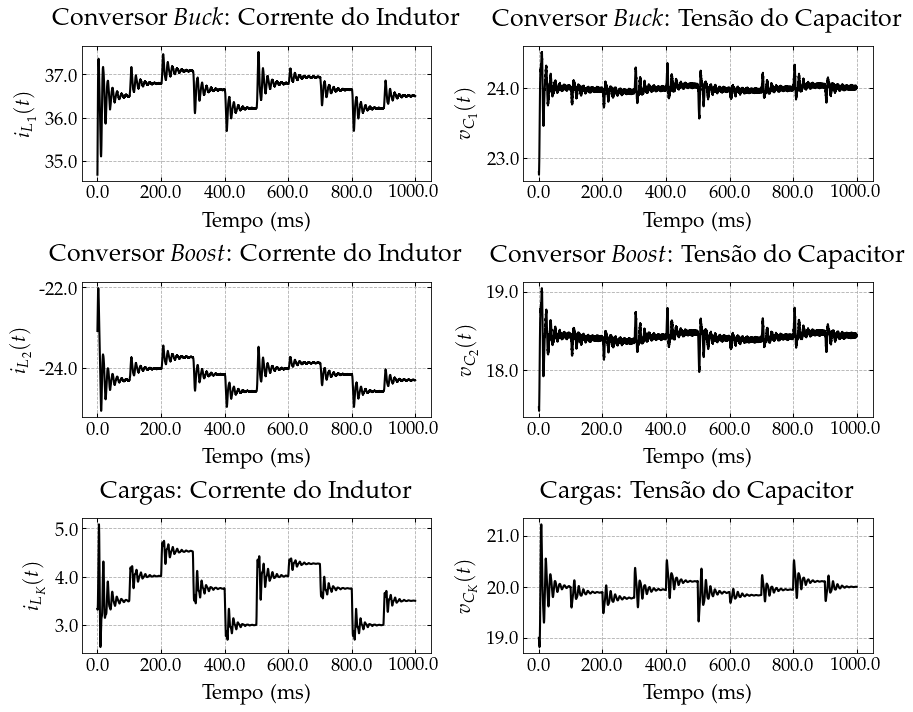

In [11]:
titles = [
    'Conversor $\it{Buck}$: Corrente do Indutor',
    'Conversor $\it{Buck}$: Tensão do Capacitor',
    'Conversor $\it{Boost}$: Corrente do Indutor',
    'Conversor $\it{Boost}$: Tensão do Capacitor',
    'Cargas: Corrente do Indutor',
    'Cargas: Tensão do Capacitor',
]

y_indices = [0, 3, 1, 4, 2, 5]
X_OP_indices = [0, 3, 1, 4, 2, 5]
x_labels = ['Tempo (ms)'] * 6
y_labels = ['$i_{L_1}(t)$', '$v_{C_1}(t)$', '$i_{L_2}(t)$',
            '$v_{C_2}(t)$', '$i_{L_K}(t)$', '$v_{C_K}(t)$']
line_colors = ['black'] * 6

fig, axs = plt.subplots(3, 2, figsize=(12, 9.6))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i, ax in enumerate(axs.flat):
  set_subplot(
      ax,
      t * 1e3,
      # y[y_indices[i]] + X_OP[i],
      y[y_indices[i]],
      x_labels[i],
      y_labels[i],
      titles[i],
      line_color=line_colors[i]
  )

plt.tight_layout()
plt.show()

In [12]:
t, y = ct.input_output_response(
    sys=shifted_mg_system, T=timepts,
    X0=δX0, U=list(δU),
)

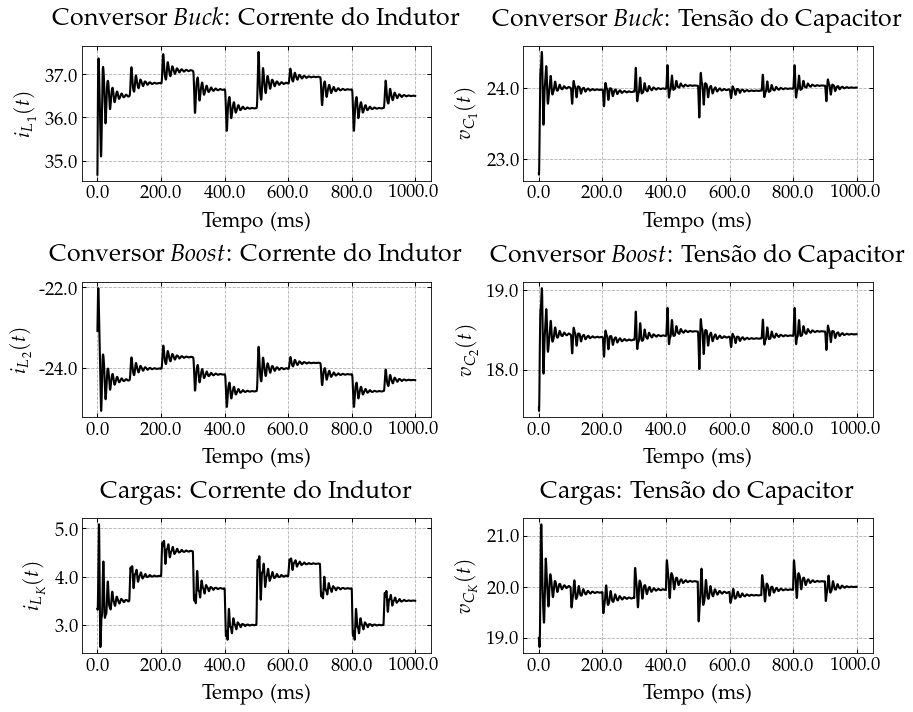

In [13]:
titles = [
    'Conversor $\it{Buck}$: Corrente do Indutor',
    'Conversor $\it{Buck}$: Tensão do Capacitor',
    'Conversor $\it{Boost}$: Corrente do Indutor',
    'Conversor $\it{Boost}$: Tensão do Capacitor',
    'Cargas: Corrente do Indutor',
    'Cargas: Tensão do Capacitor',
]

y_indices = [0, 3, 1, 4, 2, 5]
X_OP_indices = [0, 3, 1, 4, 2, 5]
x_labels = ['Tempo (ms)'] * 6
y_labels = ['$i_{L_1}(t)$', '$v_{C_1}(t)$', '$i_{L_2}(t)$',
            '$v_{C_2}(t)$', '$i_{L_K}(t)$', '$v_{C_K}(t)$']
line_colors = ['black'] * 6

fig, axs = plt.subplots(3, 2, figsize=(12, 9.6))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i, ax in enumerate(axs.flat):
  set_subplot(
      ax,
      t * 1e3,
      y[y_indices[i]] + X_OP[X_OP_indices[i]],
      x_labels[i],
      y_labels[i],
      titles[i],
      line_color=line_colors[i]
  )

plt.tight_layout()
plt.show()

In [14]:
# Parâmetros (Fuzzy)

import itertools


def He(X):
  return X + X.T


def z1(x):
  VCK = x[5]
  return 1. / (VCK_O + VCK)


def z2(x):
  return x[4]


def z3(x):
  return x[1]


z = [z1, z2, z3]
# VCK_MIN = 18
# VCK_MAX = 22
# VC2_MIN = 17
# VC2_MAX = 20
# IL2_MIN = -24
# IL2_MAX = -20

VCK_MIN = 18
VCK_MAX = 24
VC2_MIN = 16
VC2_MAX = 24
IL2_MIN = -26
IL2_MAX = -20

z_bounds = [
    [1. / VCK_MAX, 1. / VCK_MIN],
    [VC2_MIN - VC2_O, VC2_MAX - VC2_O],
    [IL2_MIN - IL2_O, IL2_MAX - IL2_O],
]

show_matrix(np.array(z_bounds))

A = {}
B = {}
E = {}
K_TIL = {}

B3 = list(itertools.product([0, 1], repeat=3))

for i in B3:
  A11 = - (R11 / L1)
  A14 = - (1. / L1)
  A22 = -(R21 / L2)
  A25 = ((R21 * IL2_O) / (L2 * VC2_O)) - VIN2 / (L2 * VC2_O)
  A33 = - (RK + REQ) / LK
  A34 = REQ / (R12 * LK)
  A35 = REQ / (R22 * LK)
  A36 = - 1 / LK
  A41 = 1. / C1
  A43 = - (REQ / (R12 * C1))
  A44 = - (1. / (R12 * C1)) * (1. - (REQ / R12))
  A45 = 1. / (C1 * (R12 + R22))
  A52 = (1. / C2) * (1 - D2_O)
  A53 = - (REQ / (R12 * C2))
  A54 = 1. / (C2 * (R12 + R22))
  A55 = - (1. / (R22 * C1)) * (1. - (REQ / R22))
  A63 = 1. / CK

  A66 = (PCPL_OP / (CK * VCK_O)) * z_bounds[0][i[0]] - 1. / (RCRL * CK)

  A[i] = cp.Parameter((6, 6), value=np.array([[A11, 0.0, 0.0, A14, 0.0, 0.0],
                                              [0.0, A22, 0.0, 0.0, A25, 0.0],
                                              [0.0, 0.0, A33, A34, A35, A36],
                                              [A41, 0.0, A43, A44, A45, 0.0],
                                              [0.0, A52, A53, A54, A55, 0.0],
                                              [0.0, 0.0, A63, 0.0, 0.0, A66]]))

  B11 = (VIN1) / L1
  B22 = (VC2_O + z_bounds[1][i[1]]) / L2
  B33 = - (REQ / LK)
  B43 = - (REQ / (R12 * C1))
  B52 = - (1. / C2) * (IL2_O + z_bounds[2][i[2]])
  B53 = - (REQ / (R12 * C2))

  B[i] = cp.Parameter((6, 3), value=np.array([[B11, 0.0, 0.0],
                                              [0.0, B22, 0.0],
                                              [0.0, 0.0, B33],
                                              [0.0, 0.0, B43],
                                              [0.0, B52, B53],
                                              [0.0, 0.0, 0.0]]))

  E63 = - (1. / CK) * z_bounds[0][i[0]]

  E[i] = cp.Parameter((6, 1), value=np.array([[0.0],
                                              [0.0],
                                              [0.0],
                                              [0.0],
                                              [0.0],
                                              [E63]]))

for i in B3:
  K_TIL[i] = cp.Variable((3, 6), name=f'K{i}')

# μ = cp.Parameter(value=11)
I1 = cp.Parameter((1, 1), value=np.eye(1))
I6 = cp.Parameter((6, 6), value=np.eye(6))
Z3 = cp.Parameter((3, 3), value=np.zeros((3, 3)))
Z6 = cp.Parameter((6, 6), value=np.zeros((6, 6)))
Z16 = cp.Parameter((1, 6), value=np.zeros((1, 6)))
Z61 = Z16.T

Ξ_TIL = cp.Variable((6, 6), name='Ξ_TIL', PSD=True)
μ = cp.Variable(name='μ')
Ψ_TIL = cp.Variable((6, 6), name='Ψ_TIL', PSD=True)
X = cp.Variable((6, 6), name='X', PSD=True)
Q = cp.Variable((6, 6), name='Q', PSD=True)

constraints = []

sum_y = 0

for i in B3:
  for j in B3:
    Y11 = He(A[i] @ X + B[i] @ K_TIL[j])
    Y12 = B[i] @ K_TIL[j]
    Y13 = E[i]
    Y14 = X
    Y15 = X

    Y22 = - Ξ_TIL
    Y33 = -μ * I1
    Y44 = - Ψ_TIL
    Y55 = -I6

    # Combine the matrix blocks into a single matrix for the LMI constraint
    Y = cp.bmat([
        [Y11,   Y12,   Y13,   Y14,  Y15],
        [Y12.T, Y22,   Z61,   Z6,   Z6],
        [Y13.T, Z61.T, Y33,   Z16,  Z16],
        [Y14.T, Z6.T,  Z16.T, Y44,  Z6],
        [Y15.T, Z6.T,  Z16.T, Z6.T, Y55],
    ])

    sum_y += Y

N = cp.bmat([
    [-Q, I6],
    [I6, -X]
])

constraints += [sum_y << 0]
constraints += [N << 0]
constraints += [μ * np.eye(1) << 0.03]

# Define the objective function and constraints
obj = cp.Minimize(cp.trace(Ξ_TIL + Ψ_TIL + Q))

# Define the optimization problem
prob = cp.Problem(obj, constraints)

# Solve the problem using the MOSEK solver
prob.solve(solver=cp.MOSEK, verbose=False)

K = {}
Ξ = None
Ψ = None
P = None

# Display the results
if prob.status not in ["infeasible", "unbounded"]:
  print("Optimal value: %s\n" % prob.value)
  # for variable in prob.variables():
  #   if len(variable.shape) == 2:
  #     show_matrix(variable.name(), variable.value)
  #   else:
  #     print(variable.name(), '=', variable.value, '\n')

  # # Compute the inverse of X and use it to calculate Ξ and K
  X_INV = np.linalg.inv(X.value)
  Ξ = X_INV @ Ξ_TIL.value @ X_INV
  Ψ = np.linalg.inv(Ψ_TIL.value)
  P = X_INV

  show_matrix(P, name='P')
  show_matrix(Ξ, name='Ξ')
  show_matrix(Ψ, name='Ψ')
  print('μ', μ.value)

  # _K = K_TIL @ X_INV
  # K = _K.value

  for i in B3:
    K[i] = K_TIL[i].value @ X_INV
    show_matrix(K[i], f'K[{i}]')

  # show_matrix('K', K)

  # show_matrix('Ξ', Ξ)
  # show_matrix('Ψ', Ψ)
else:
  print('The problem is not feasible')

ans =
    ┌                     ┐
    │  4.17e-02  5.56e-02 │
    │ -2.45e+00  5.55e+00 │
    │ -1.71e+00  4.29e+00 │
    └                     ┘

Optimal value: 11788.080440819293

P =
    ┌                                                                  ┐
    │  1.80e-02  -4.14e-03  -6.66e-04  -1.85e-02   2.13e-02  -4.28e-03 │
    │ -4.14e-03   2.20e-02   1.95e-03   1.63e-02  -1.56e-02  -4.79e-03 │
    │ -6.66e-04   1.95e-03   2.14e-02   1.02e-02   1.01e-02   1.67e-02 │
    │ -1.85e-02   1.63e-02   1.02e-02   1.89e-01  -1.52e-01   1.15e-02 │
    │  2.13e-02  -1.56e-02   1.01e-02  -1.52e-01   1.93e-01   9.81e-03 │
    │ -4.28e-03  -4.79e-03   1.67e-02   1.15e-02   9.81e-03   4.86e-02 │
    └                                                                  ┘

Ξ =
    ┌                                                            ┐
    │ 7.29e-02  1.22e-02  6.20e-01  7.82e-01  1.00e+00  8.94e-01 │
    │ 1.22e-02  2.06e-03  1.04e-01  1.31e-01  1.68e-01  1.50e-01 │
    │ 6.20e-01  1.04e-01

In [15]:
# θ = 1e-3
θ = 1
λ = 100

event_times = [0.]


def get_gama(current_states, last_states_sent):

  error = last_states_sent - current_states

  _zt_cur_states = [z1(current_states),
                    z2(current_states),
                    z3(current_states),]

  _zt_lss = [z1(last_states_sent),
             z2(last_states_sent),
             z3(last_states_sent),]

  _M_cur_states = []
  _M_lss = []

  for i in range(0, 3):
    m_cur_states = (_zt_cur_states[i] - z_bounds[i][0]) / \
        (z_bounds[i][1] - z_bounds[i][0])

    m_lss = (_zt_lss[i] - z_bounds[i][0]) / \
        (z_bounds[i][1] - z_bounds[i][0])

    if m_cur_states < 0 or m_cur_states > 1:
      raise ValueError(
          f"Função Get Gamma: As funções de pertinência estão foram do limite {i}.\n x: {current_states + X_OP}\n x_hat: {last_states_sent + X_OP}")

    _M_cur_states.append([1. - m_cur_states, m_cur_states])
    _M_lss.append([1. - m_lss, m_lss])

  Kx, Ke, Bx = 0, 0, 0

  for p in B3:
    _σp_cur_states = 1.
    _σp_error = 1.
    for i, b in enumerate(p):
      _σp_cur_states *= _M_cur_states[i][b]
      _σp_error *= _M_lss[i][b]

    Kx += _σp_cur_states * K[p]
    Ke += _σp_error * K[p]
    Bx += _σp_cur_states * B[p].value

  ζ = 2 * current_states.T @ P @ Bx @ (Ke - Kx) @ last_states_sent
  return current_states.T @ Ψ @ current_states - error.T @ Ξ @ error - ζ


def etm_update(t, n, u, params):
  Γ = get_gama(current_states=u[6:12],
               last_states_sent=u[0:6])
  dλ = -λ * n + Γ
  return [dλ]


def etm_output(t, n, u, params):
  global zero, event_times

  if t != etm_output.previous_time:
    etm_output.previous_time = t
    if etm_output.first_simulation and t == 0.:
      etm_output.first_simulation = False

  last_states_sent = u[0:6]
  current_states = u[6:12]

  Γ = get_gama(current_states, last_states_sent)

  trigger = (n + θ * Γ) < 0

  if etm_output.first_simulation and event_times[-1] != t and trigger:
    event_times.append(t)

  state_to_sent = (
      current_states if trigger[0] or t == 0. else last_states_sent)

  return [trigger[0], state_to_sent[0], state_to_sent[1], state_to_sent[2], state_to_sent[3], state_to_sent[4], state_to_sent[5], n[0]]


etm_output.previous_time = 0
etm_output.first_simulation = True

ETM = ct.NonlinearIOSystem(
    etm_update, etm_output,
    name='etm',
    states=('n'),
    inputs=('x1_hat', 'x2_hat', 'x3_hat', 'x4_hat',
            'x5_hat', 'x6_hat', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6'),
    outputs=('Γ', 'x1_tk', 'x2_tk', 'x3_tk', 'x4_tk',
             'x5_tk', 'x6_tk', 'n'),
)


def zoh_output(t, x, u, params):
  if t != zoh_output.previous_time:
    zoh_output.last_states_sent = zoh_output.previous
    zoh_output.previous_time = t
  zoh_output.previous = u
  return zoh_output.last_states_sent


zoh_output.previous_time = 0
zoh_output.previous = []
zoh_output.last_states_sent = [0, 0, 0, 0, 0, 0]

ZOH = ct.ss(
    None, zoh_output,
    name='zoh',
    inputs=('x1', 'x2', 'x3', 'x4', 'x5', 'x6'),
    outputs=('x1_hat', 'x2_hat', 'x3_hat', 'x4_hat',
             'x5_hat', 'x6_hat'),
)


def control_output(t, x, u, params):
  _states_received = u[0:6]

  _zt = [z1(_states_received),
         z2(_states_received),
         z3(_states_received),]

  _M = []
  for i in range(0, 3):
    m = (_zt[i] - z_bounds[i][0]) / (z_bounds[i][1] - z_bounds[i][0])

    if m < 0 or m > 1:
      raise ValueError(
          "Controlador: As funções de pertinência estão foram do limite.")
    _M.append([1. - m, m])
    # print(_M[i])

  u = 0
  for p in B3:
    _σp = 1.
    for i, b in enumerate(p):
      _σp *= _M[i][b]
    u += _σp * K[p] @ _states_received

  # print(t, u)
  return u


CONTROL = ct.NonlinearIOSystem(
    None, control_output,
    name='control',
    inputs=('x1_hat', 'x2_hat', 'x3_hat', 'x4_hat',
            'x5_hat', 'x6_hat'),
    outputs=('u1', 'u2', 'u3'),
)

# print(ETM)
# print(ZOH)
# print(CONTROL)


CLOSED_LOOP_SYSTEM = ct.interconnect(
    (shifted_mg_system, ETM, ZOH, CONTROL),
    connections=(
        # Connection between controller output and plant
        ('shifted_microgrid.δd1', 'control.u1'),
        ('shifted_microgrid.δd2', 'control.u2'),
        ('shifted_microgrid.δiB', 'control.u3'),

        # Connection between ZOH and plant outputs to ETM
        ('etm.x1_hat', 'zoh.x1_hat'),
        ('etm.x2_hat', 'zoh.x2_hat'),
        ('etm.x3_hat', 'zoh.x3_hat'),
        ('etm.x4_hat', 'zoh.x4_hat'),
        ('etm.x5_hat', 'zoh.x5_hat'),
        ('etm.x6_hat', 'zoh.x6_hat'),

        ('etm.x1', 'shifted_microgrid.δiL1'),
        ('etm.x2', 'shifted_microgrid.δiL2'),
        ('etm.x3', 'shifted_microgrid.δiLK'),
        ('etm.x4', 'shifted_microgrid.δvC1'),
        ('etm.x5', 'shifted_microgrid.δvC2'),
        ('etm.x6', 'shifted_microgrid.δvCK'),

        # Connecting the ETM output to the ZOH
        ('zoh.x1', 'etm.x1_tk'),
        ('zoh.x2', 'etm.x2_tk'),
        ('zoh.x3', 'etm.x3_tk'),
        ('zoh.x4', 'etm.x4_tk'),
        ('zoh.x5', 'etm.x5_tk'),
        ('zoh.x6', 'etm.x6_tk'),

        # Connecting the ZOH output to the controller
        ('control.x1_hat', 'zoh.x1_hat'),
        ('control.x2_hat', 'zoh.x2_hat'),
        ('control.x3_hat', 'zoh.x3_hat'),
        ('control.x4_hat', 'zoh.x4_hat'),
        ('control.x5_hat', 'zoh.x5_hat'),
        ('control.x6_hat', 'zoh.x6_hat'),
    ),
    name='closed-loop system',
    inplist=('shifted_microgrid.δPl'),
    outlist=('shifted_microgrid.δiL1',
             'shifted_microgrid.δiL2',
             'shifted_microgrid.δiLK',
             'shifted_microgrid.δvC1',
             'shifted_microgrid.δvC2',
             'shifted_microgrid.δvCK',
             'etm.Γ',
             'etm.n',
             'shifted_microgrid.δd1',
             'shifted_microgrid.δd2',
             'shifted_microgrid.δiB',
             ),
    output=('IL1', 'IL2', 'ILK', 'VC1', 'VC2',
            'VCK', 'Γ', 'n', 'D1', 'D2', 'IB')
)

t, y = ct.input_output_response(
    sys=CLOSED_LOOP_SYSTEM, T=timepts,
    X0=np.append(δX0, 0.),
    U=δW[0],
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step}
)

### Apresentação dos Resultados em Malha Fechada sob o ETC Dinâmico

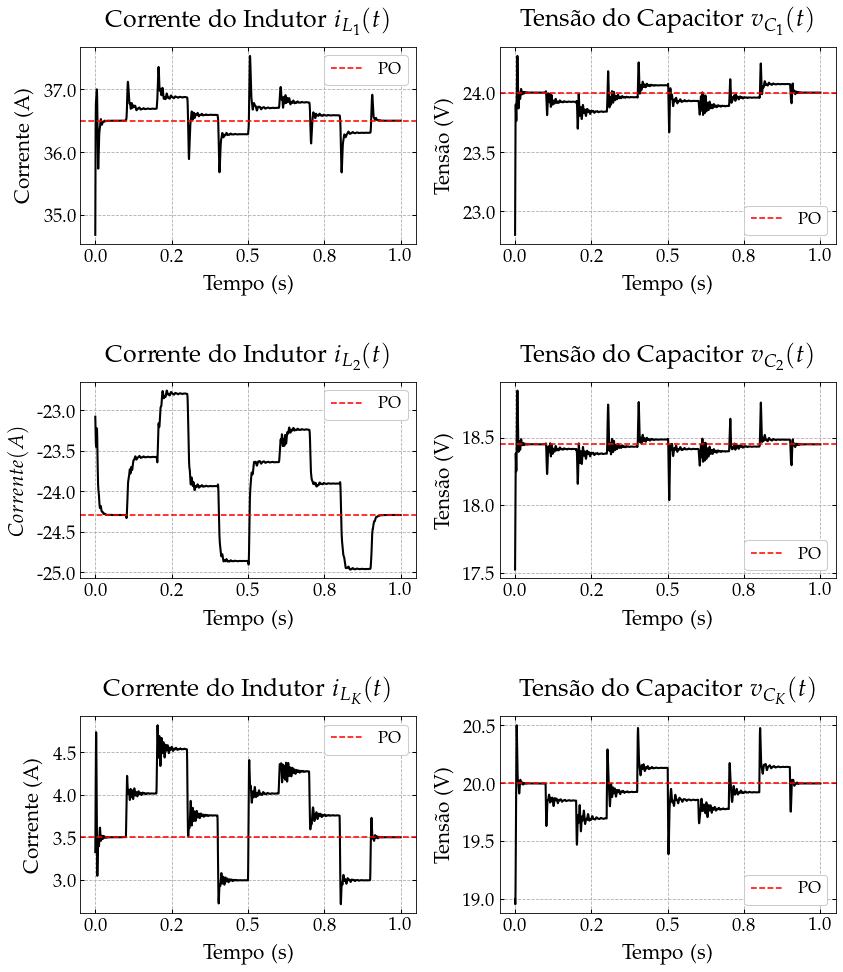

In [16]:
titles = [
    'Corrente do Indutor $i_{L_1}(t)$',
    'Tensão do Capacitor $v_{C_1}(t)$',
    'Corrente do Indutor $i_{L_2}(t)$',
    'Tensão do Capacitor $v_{C_2}(t)$',
    'Corrente do Indutor $i_{L_K}(t)$',
    'Tensão do Capacitor $v_{C_K}(t)$',
]

y_indices = [0, 3, 1, 4, 2, 5]
X_OP_indices = [0, 3, 1, 4, 2, 5]
x_labels = ['Tempo (s)'] * 6
y_labels = ['Corrente (A)', 'Tensão (V)', '$Corrente (A)$',
            'Tensão (V)', 'Corrente (A)', 'Tensão (V)']
line_colors = ['black'] * 6

fig, axs = plt.subplots(3, 2, figsize=(13, 15))
plt.subplots_adjust(wspace=0.25, hspace=.7)

for i, ax in enumerate(axs.flat):
  set_subplot(
      ax,
      t,
      y[y_indices[i]] + X_OP[X_OP_indices[i]],
      x_labels[i],
      y_labels[i],
      titles[i],
      line_color=line_colors[i]
  )
  ax.axhline(y=X_OP[X_OP_indices[i]], color='r',
             linestyle='--', label='PO')
  ax.legend(frameon=True, loc='best', framealpha=1, prop={'size': 16})
path = f"States.eps"
plt.savefig(path, format='eps', bbox_inches='tight')

### Sinal de Controle e Variável Dinâmica

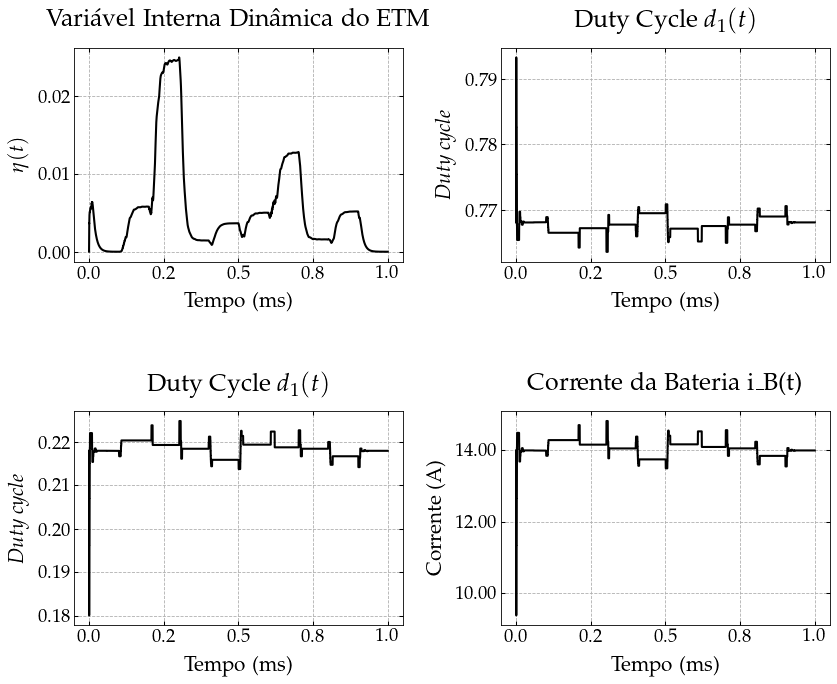

In [17]:
titles = [
    'Variável Interna Dinâmica do ETM',
    'Duty Cycle $d_1(t)$',
    'Duty Cycle $d_1(t)$',
    'Corrente da Bateria i_B(t)',
]

y_indices = [7, 8, 9, 10]
x_labels = ['Tempo (ms)'] * 4
y_labels = ['$\eta(t)$', '${\\textit{Duty cycle}}$',
            '${\\textit{Duty cycle}}$', 'Corrente (A)',]
line_colors = ['black'] * 4

fig, axs = plt.subplots(2, 2, figsize=(13, 10))
plt.subplots_adjust(wspace=0.3, hspace=.7)

op = [np.array([0.]), np.array([U_OP[0]]),
      np.array([U_OP[1]]), np.array([U_OP[2]])]

# y[7] *= 1e4

for i, ax in enumerate(axs.flat):
  set_subplot(
      ax,
      t,
      y[y_indices[i]] + op[i],
      x_labels[i],
      y_labels[i],
      titles[i],
      line_color=line_colors[i],
      y_digits=2
  )

path = f"DynamicVariable_InputsSignal.eps"
plt.savefig(path, format='eps', bbox_inches='tight')

### Intervalo de Tempo entre Eventos

In [18]:
event_times = list(event_times)

inter_event_times = [0.]

for i in range(1, len(event_times)):
  inter_event_times.append(
      event_times[i] - event_times[i-1])

189
2.1792411908724256e-07
0.09884713546326887


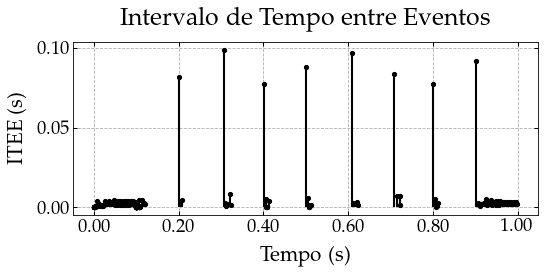

In [19]:
fig, ax = plt.subplots(figsize=(8, 3))

# print(event_times)

set_stem(ax, [et for et in event_times],
         [et for et in inter_event_times],
         xlabel='Tempo (s)', ylabel='ITEE (s)',
         title='Intervalo de Tempo entre Eventos', line_color='black')

path = f"Inter-Event-Time.eps"
plt.savefig(path, format='eps', bbox_inches='tight')

print(len(event_times))
print(min(inter_event_times[1:]))
print(max(inter_event_times))

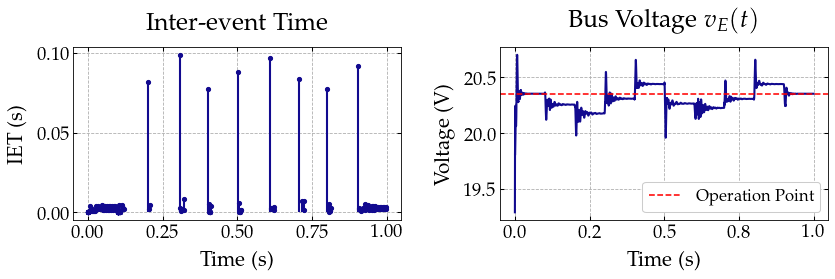

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(13, 3))
plt.subplots_adjust(wspace=0.3, hspace=.7)

# print(event_times)

ve_o = (REQ / R12) * X_OP[3] + (REQ / R22) * \
    X_OP[4] - REQ * U_OP[2] - REQ * X_OP[2]
ve = (REQ / R12) * y[3] + (REQ / R22) * y[4] - REQ * y[10] - REQ * y[2]

set_stem(ax[0], [et for et in event_times],
         [et for et in inter_event_times],
         xlabel='Time (s)', ylabel='IET (s)',
         title='Inter-event Time')

set_subplot(ax[1], t, ve + ve_o,
            xlabel='Time (s)', ylabel='Voltage (V)',
            title='Bus Voltage $v_E(t)$')
ax[1].axhline(y=ve_o, color='r',
              linestyle='--', label='Operation Point')
ax[1].legend(frameon=True, loc='best', framealpha=1, prop={'size': 16})

path = f"Bus_Voltage_IETs.eps"
plt.savefig(path, format='eps', bbox_inches='tight')